# Policy Gradients on CartPole with PyTorch 1.0

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [11]:
env = gym.make('CartPole-v1')
env.seed(1)
torch.manual_seed(1)

# Hyperparameters
learning_rate = 0.01
gamma = 0.99

# Define model and training loop

In [12]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128

        self.l1 = nn.Linear(state_space, num_hidden, bias=False)
        self.l2 = nn.Linear(num_hidden, action_space, bias=False)

        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy and reward history
        self.episode_actions = torch.Tensor([])
        self.episode_rewards = []

    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)


def predict(state):
    # Select an action (0 or 1) by running policy model
    # and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    action_probs = policy(state)
    distribution = Categorical(action_probs)
    action = distribution.sample()

    # Add log probability of our chosen action to our history
    policy.episode_actions = torch.cat([
        policy.episode_actions,
        distribution.log_prob(action).reshape(1)
    ])

    return action


def update_policy():
    R = 0
    rewards = []

    # Discount future rewards back to the present using gamma
    for r in policy.episode_rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)

    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / \
        (rewards.std() + np.finfo(np.float32).eps)

    # Calculate loss
    loss = (torch.sum(torch.mul(policy.episode_actions, rewards).mul(-1), -1))

    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.episode_rewards))
    policy.reset()


def train(episodes):
    scores = []
    for episode in range(episodes):
        # Reset environment and record the starting state
        state = env.reset()

        for time in range(1000):
            action = predict(state)

            # Uncomment to render the visual state in a window
            # env.render()

            # Step through environment using chosen action
            state, reward, done, _ = env.step(action.item())

            # Save reward
            policy.episode_rewards.append(reward)
            if done:
                break

        update_policy()

        # Calculate score to determine when the environment has been solved
        scores.append(time)
        mean_score = np.mean(scores[-100:])

        if episode % 50 == 0:
            print('Episode {}\tAverage length (last 100 episodes): {:.2f}'.format(
                episode, mean_score))

        if mean_score > env.spec.reward_threshold:
            print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
                  .format(episode, mean_score, time))
            break

# Start training

In [13]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
train(episodes=1000)

Episode 0	Average length (last 100 episodes): 8.00
Episode 50	Average length (last 100 episodes): 24.22
Episode 100	Average length (last 100 episodes): 63.07
Episode 150	Average length (last 100 episodes): 120.44
Episode 200	Average length (last 100 episodes): 275.69
Episode 250	Average length (last 100 episodes): 447.72
Episode 300	Average length (last 100 episodes): 440.06
Episode 350	Average length (last 100 episodes): 447.89
Solved after 379 episodes! Running average is now 475.86. Last episode ran to 499 time steps.


# Plot training performance

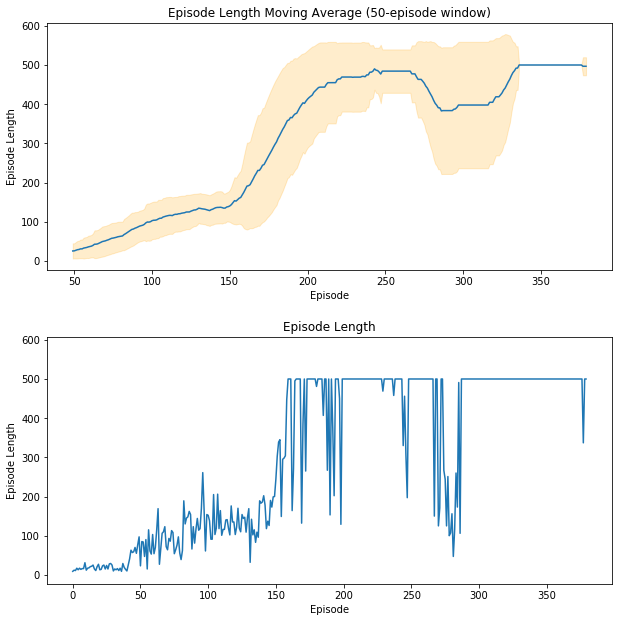

In [14]:
# number of episodes for rolling average
window = 50

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()